In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pickle
import random as rnd
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import seaborn as sns
import sklearn
import statsmodels.api as sm
import xgboost as xgb
from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.widgets import RunDetails
from matplotlib import pyplot
from matplotlib.font_manager import FontProperties
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.ensemble import (AdaBoostRegressor, BaggingClassifier,
                              BaggingRegressor, ExtraTreesRegressor,
                              GradientBoostingRegressor, RandomForestRegressor,
                              VotingRegressor)
from sklearn.feature_selection import (RFE, SelectFromModel, SelectKBest,
                                       VarianceThreshold, chi2)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import (ElasticNet, HuberRegressor, Lasso,
                                  LinearRegression, RANSACRegressor, Ridge,
                                  SGDRegressor, TheilSenRegressor)
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix, log_loss,
                             precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import (GridSearchCV, KFold, RandomizedSearchCV,
                                     ShuffleSplit, StratifiedKFold,
                                     cross_val_score, cross_validate,
                                     train_test_split)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (Binarizer, LabelEncoder, MinMaxScaler,
                                   Normalizer, OneHotEncoder,
                                   PolynomialFeatures, StandardScaler,
                                   normalize)
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from lightgbm import LGBMRegressor

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


In [3]:
traindf = pd.read_csv('../data/train.csv', index_col="ID")
traindf.sample(2)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
74448,Resort Hotel,0,17,2016,November,48,26,0,1,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,D,0,No Deposit,242.0,NaN,0,Transient,44.269248,0,1,Check-Out,2016-11-27
81421,City Hotel,0,7,2017,January,4,23,1,0,1,0.0,0,SC,NLD,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.0,NaN,0,Transient,104.897345,0,2,Check-Out,2017-01-24


### Drop columns not in test data and Clean missing data
* Drop columns: `adr`, `reservation_status`, `reservation_status_date`

In [4]:
testCol = set(pd.read_csv('../data/test.csv', index_col="ID").columns)
removeCols = [col for col in traindf.columns if col not in testCol]
removeCols.remove("is_canceled")
print(removeCols)

['adr', 'reservation_status', 'reservation_status_date']


In [5]:
traindf = traindf.drop(['reservation_status', 'reservation_status_date'], axis=1)
traindf.sample(2)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
87153,City Hotel,1,46,2017,March,9,3,1,2,3,0.0,0,BB,URY,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient,145.724980,0,1
87721,City Hotel,1,34,2017,March,10,7,2,9,1,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,8.0,NaN,0,Transient,94.349075,0,0


### Drop outliers

* Drop if booking is canceled
* Drop if adr is lower than 0 and higher than 400

In [6]:
traindf = traindf[traindf["is_canceled"] == 0]
traindf = traindf[(traindf["adr"] > 0) & (traindf["adr"] < 400)]

In [7]:
traindf.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,City Hotel,0,257,2015,July,27,1,0,2,1,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,1,No Deposit,6.0,NaN,0,Transient,75.052227,0,0
2,City Hotel,0,257,2015,July,27,1,0,2,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6.0,NaN,0,Transient,74.546401,0,0
3,City Hotel,0,257,2015,July,27,1,0,2,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6.0,NaN,0,Transient,76.376288,0,0
4,City Hotel,0,257,2015,July,27,1,0,2,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6.0,NaN,0,Transient,49.411647,0,0
5,City Hotel,0,257,2015,July,27,1,0,2,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6.0,NaN,0,Transient,92.832887,0,0


### The below code shows column name of missing data

* The company feature's 94% is missing. Because of that, this feature will be eliminated. 
* Another missing data has occurred in country and agent features. Since missing data of country is less than 1%, these data will replace with most frequent value. 
* However, the agent missing features are more than the country. For this feature, missing data will be imputed as 0

In [8]:
traindf["children"] = traindf["children"].fillna(0)
traindf["country"] = traindf["country"].fillna(traindf["country"].mode().index[0])
traindf["agent"] = traindf["agent"].fillna("0")
traindf = traindf.drop(["company"], axis=1)

In [9]:
traindf.sample(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
84568,Resort Hotel,0,1,2017,February,7,16,0,3,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,0,Transient,44.357077,0,2
51952,Resort Hotel,0,119,2016,July,30,20,1,4,2,0.0,0,BB,PRT,Online TA,Direct,0,0,0,D,D,0,No Deposit,0,0,Transient,156.584781,0,1
17928,Resort Hotel,0,105,2015,November,47,18,2,4,2,0.0,0,Undefined,ESP,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,313,65,Transient-Party,50.830504,0,0
55141,City Hotel,0,189,2016,August,33,9,0,1,2,0.0,0,BB,FRA,Direct,Direct,0,0,0,A,A,2,No Deposit,14,0,Transient,76.357571,0,0
81619,City Hotel,0,0,2017,January,4,25,0,3,1,0.0,0,BB,CHN,Online TA,Corporate,0,0,0,B,B,0,No Deposit,0,0,Transient,89.554669,0,0


### Feature Transformation

* `date`: Combine `arrival_date_year`, `arrival_date_month`, `arrival_date_week_number` to date object
<br>One hot encoding `arrival_date_month`

In [10]:
traindf

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,City Hotel,0,257,2015,July,27,1,0,2,1,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,1,No Deposit,6,0,Transient,75.052227,0,0
2,City Hotel,0,257,2015,July,27,1,0,2,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,0,Transient,74.546401,0,0
3,City Hotel,0,257,2015,July,27,1,0,2,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,0,Transient,76.376288,0,0
4,City Hotel,0,257,2015,July,27,1,0,2,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,0,Transient,49.411647,0,0
5,City Hotel,0,257,2015,July,27,1,0,2,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,0,Transient,92.832887,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91524,Resort Hotel,0,64,2017,March,13,31,0,1,2,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,251,0,Transient,48.430353,0,0
91525,Resort Hotel,0,72,2017,March,13,31,3,7,2,0.0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,A,E,1,No Deposit,40,0,Contract,79.453407,0,1
91528,Resort Hotel,0,2,2017,March,13,31,0,1,2,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,F,1,No Deposit,0,0,Transient,90.814554,0,2


In [11]:
def create_time_feature(df: pd.DataFrame, year: pd.Series, month: pd.Series, date: pd.Series) -> pd.Series:
    data = df.copy()
    data["date"] = pd.to_datetime(year.astype(str) + month + date.astype(str), format="%Y%B%d")
    data = pd.get_dummies(data, columns=["arrival_date_month"])
    data["weekday"] = data["date"].dt.weekday
    data["is_weekend"] = ((data["weekday"] == 5) | (data["weekday"] == 6)).astype("float")
    data = data.drop(["arrival_date_year", "arrival_date_day_of_month", "weekday"], axis=1)
    
    return data

traindf = create_time_feature(traindf, traindf["arrival_date_year"], 
                              traindf["arrival_date_month"], traindf["arrival_date_day_of_month"])

`hotel`: Convert hotel as `Resort Hotel` to 0, `City Hotel` to 1

In [12]:
traindf["hotel"] = traindf["hotel"].map({"Resort Hotel": 0, "City Hotel": 1})

Create new feature `is_same_room`: Check if `reserved_room_type` is same as `assigned_room_type`(If so 1, else 0)
<br>One hot encoding `reserved_room_type` and `assigned_room_type`

In [13]:
traindf["is_same_room"] = (traindf["reserved_room_type"] == traindf["assigned_room_type"]).map({True: 1, False: 0})
reserved = pd.get_dummies(traindf.reserved_room_type, prefix="reserved")
assigned = pd.get_dummies(traindf.assigned_room_type, prefix="assigned")
traindf = pd.concat([traindf, reserved, assigned], axis=1, join="inner")
traindf = traindf.drop(["reserved_room_type", "assigned_room_type"], axis=1)

In [14]:
traindf["total_nights"] = traindf["stays_in_weekend_nights"] + traindf["stays_in_week_nights"]
traindf = traindf[traindf["total_nights"] > 0]
traindf["long_stay"] = (traindf["total_nights"] > 5).astype("float")

`children`: `children` + `babies`

In [15]:
traindf["total_customers"] = traindf["adults"] + traindf["children"] + traindf["babies"]
traindf = traindf[traindf["total_customers"] <= 5]

In [16]:
traindf["children"] = traindf["children"] + traindf["babies"]
traindf = traindf.drop(["babies"], axis=1)

One hot encoding: `meal`

In [17]:
traindf = pd.get_dummies(traindf, columns=["meal"])

Classify `country` to `proneToCancel`, `neutralToCancel`, `notProneToCancel` based on canceled rate
* `proneToCancel`: canceled rate >= 0.5
* `neutralToCancel`: 0.3 < canceled rate < 0.5
* `notProneToCancel`: canceled rate <= 0.3

In [18]:
def country_adr_level(traindf):
    tmp = traindf[["country", "adr"]].groupby("country").agg({'country': 'count', 'adr': 'mean'})
    lowAdrCountry = set(tmp[tmp.adr < 80]["country"].index)
    midAdrCountry = set(tmp[(tmp.adr <= 90) & (tmp.adr >= 80)]["country"].index)
    highAdrCountry = set(tmp[tmp.adr > 90]["country"].index)
    
    traindf["lowAdrCountry"] = traindf["country"].apply(lambda x: 1 if x in lowAdrCountry else 0)
    traindf["midAdrCountry"] = traindf["country"].apply(lambda x: 1 if x in midAdrCountry else 0)
    traindf["highAdrCountry"] = traindf["country"].apply(lambda x: 1 if x in highAdrCountry else 0)
    traindf = traindf.drop(["country"], axis=1)
    
    return traindf

traindf = country_adr_level(traindf)

In [19]:
traindf["total_previos_booking"] = traindf["previous_cancellations"] + traindf["previous_bookings_not_canceled"]

Classify `agent` to `agentLikelyToCancel`, `agentProneToCancel`, `agentNeutralToCancel`, `agentNotProneToCancel` based on canceled rate
* `agentLikelyToCancel`: canceled rate > 0.75
* `agentProneToCancel`: 0.5 < canceled rate <= 0.75
* `agentNeutralToCancel`: 0.3 < canceled rate <= 0.5
* `agentNotProneToCancel`: canceled rate <= 0.3

In [20]:
def agent_adr_level(traindf):
    tmp = traindf[["agent", "adr"]].groupby("agent").agg({'agent': 'count', 'adr': 'mean'})
    lowAdrCountry = set(tmp[tmp.adr < 100]["agent"].index)
    highAdrCountry = set(tmp[tmp.adr >= 100]["agent"].index)
    
    traindf["lowAdrCountry"] = traindf["agent"].apply(lambda x: 1 if x in lowAdrCountry else 0)
    traindf["highAdrCountry"] = traindf["agent"].apply(lambda x: 1 if x in highAdrCountry else 0)
    traindf = traindf.drop(["agent"], axis=1)
    
    return traindf

traindf = agent_adr_level(traindf)

### Train Model and Evaluate best model performance

In [21]:
traindf = pd.get_dummies(traindf)
traindf = traindf.drop(["date"], axis=1)
traindf.head()

,hotel,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,is_weekend,is_same_room,reserved_A,reserved_B,reserved_C,reserved_D,reserved_E,reserved_F,reserved_G,reserved_H,reserved_L,assigned_A,assigned_B,assigned_C,assigned_D,assigned_E,assigned_F,assigned_G,assigned_H,assigned_I,assigned_K,total_nights,long_stay,total_customers,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,lowAdrCountry,midAdrCountry,highAdrCountry,total_previos_booking,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,0,257,27,0,2,1,0.0,0,0,0,1,0,75.052227,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0.0,1.0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0
2,1,0,257,27,0,2,2,0.0,0,0,0,0,0,74.546401,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0.0,2.0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0
3,1,0,257,27,0,2,2,0.0,0,0,0,0,0,76.376288,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0.0,2.0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0
4,1,0,257,27,0,2,2,0.0,0,0,0,0,0,49.411647,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0.0,2.0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0
5,1,0,257,27,0,2,2,0.0,0,0,0,0,0,92.832887,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0.0,2.0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0


In [25]:
new_train_x = traindf.drop(["adr"], axis=1).values
new_train_y = traindf["adr"].values

scaler = StandardScaler()
scaler = scaler.fit(new_train_x)
new_train_x = scaler.transform(new_train_x)

In [27]:
classifiers = [LinearRegression(normalize=True),
               ElasticNet(),
               Lasso(),
               Ridge(),
               LinearSVR(),
               AdaBoostRegressor(),
               BaggingRegressor(),
               GradientBoostingRegressor(),
               RandomForestRegressor(),
               KNeighborsRegressor(),
               XGBRegressor(objective="reg:squarederror"),
               XGBRFRegressor(objective="reg:squarederror"), 
               LGBMRegressor()
               ]

from time import time

for clf in classifiers:
    before = time()
    print("="*30)
    print(clf.__class__.__name__)
    
    crossValScore = cross_validate(clf, new_train_x, new_train_y, scoring=('r2', 'neg_mean_squared_error'), cv=5) 
    for metric, value in crossValScore.items():
        print(f"{metric}: {abs(np.mean(value)):.2f}")
    after = time()
    print(f"花費{(after - before):.1f}s")
    
print("="*30)

LinearRegression
fit_time: 0.14
score_time: 0.00
test_r2: 3654957906458756870135018810546922635449580503695360.00
test_neg_mean_squared_error: 7519466743735315469649086275505904171908254027084726272.00
花費0.7s
XGBRegressor
fit_time: 5.85
score_time: 0.03
test_r2: 0.61
test_neg_mean_squared_error: 791.51
花費29.4s
XGBRFRegressor
fit_time: 5.06
score_time: 0.02
test_r2: 0.22
test_neg_mean_squared_error: 1544.27
花費25.4s
LGBMRegressor
fit_time: 2.20
score_time: 0.07
test_r2: 0.63
test_neg_mean_squared_error: 752.01
花費11.4s


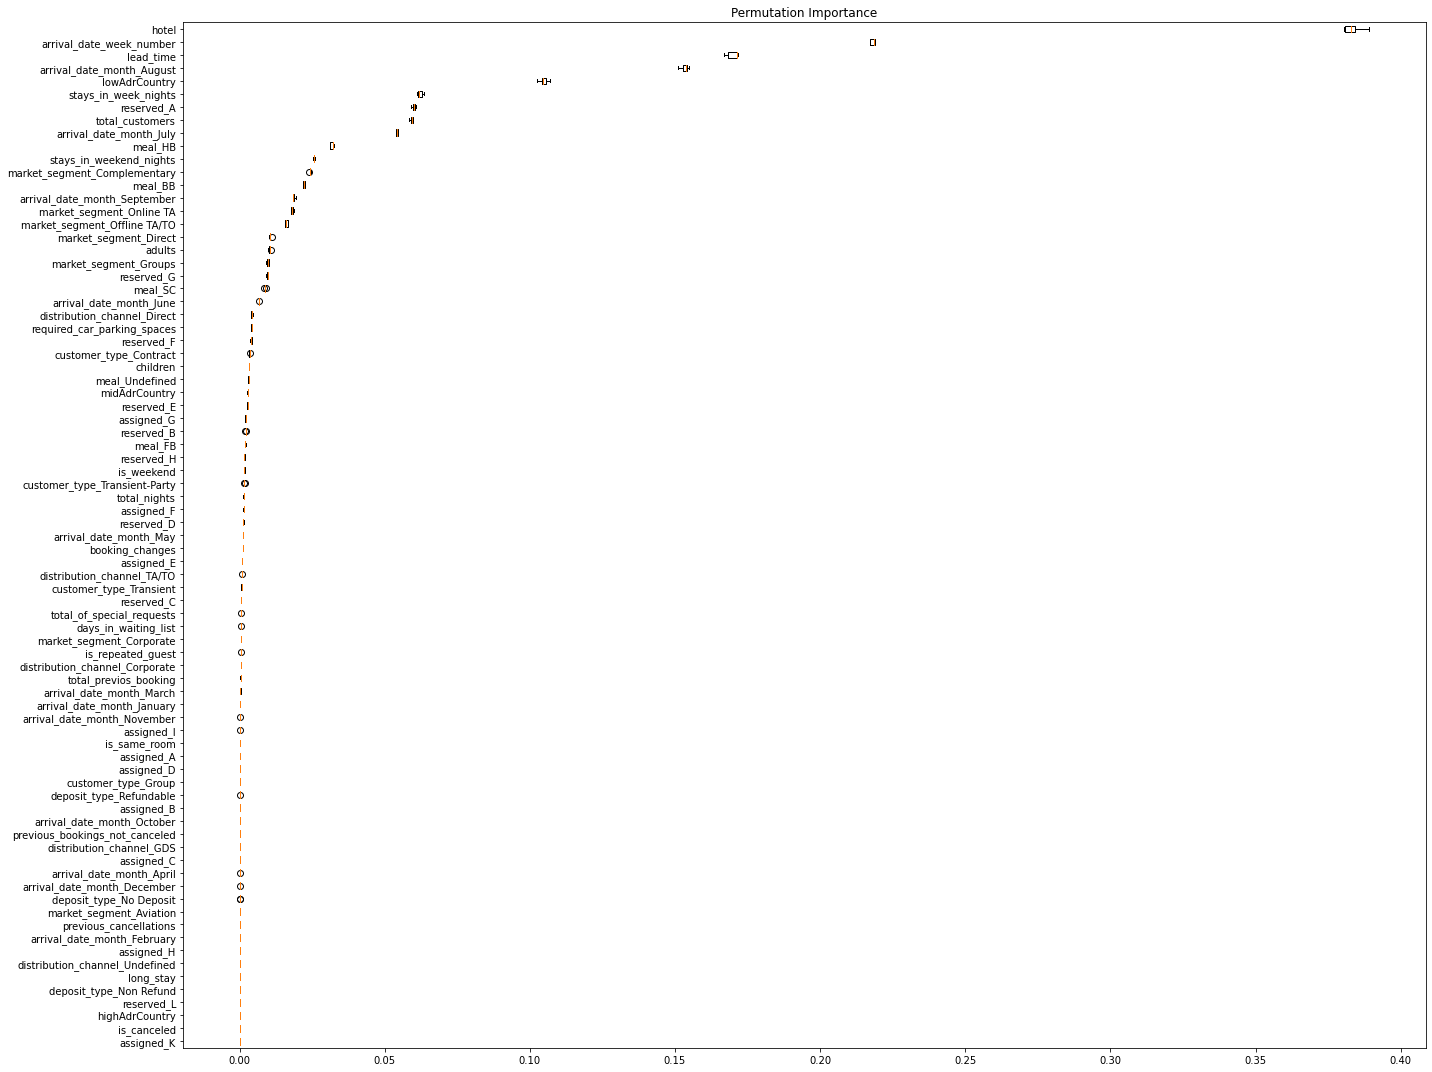

In [29]:
X_train, X_test, y_train, y_test = train_test_split(new_train_x, new_train_y, test_size=0.3)
model = LGBMRegressor()
model = model.fit(X_train, y_train)
result = permutation_importance(model, X_train, y_train, scoring="r2", n_repeats=5, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(20, 15))

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=traindf.drop("adr", axis=1).columns[sorted_idx])
ax.set_title("Permutation Importance")
fig.tight_layout()
plt.show()